# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# KNN Algorithm

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Import Required Packages

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# import model evaluation and metric related packages
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# import model related packages
from sklearn.neighbors import KNeighborsClassifier

# package for model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# package for evaluation
from scipy import interp # for ROC curve
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# for dim reduction
from sklearn.decomposition import TruncatedSVD

# for summarising the results
from prettytable import PrettyTable

# UTIL functions

## Preprocessing Related Functions

In [2]:
def preprocess_data(config_dict, scaling=True, dim_reduction=False):
    """
    This function does preprocessing of data such as column standardization and
    dimensionality reduction using Truncated SVD
    """
    
    # Read train, test data frames & truncate it as needed
    train_df = pd.read_csv(config_dict['train_csv_path'], index_col=False)
    train_df = train_df.iloc[0:config_dict['train_size']]
    test_df = pd.read_csv(config_dict['test_csv_path'], index_col=False)
    test_df = test_df.iloc[0:config_dict['test_size']]

    # print the statisics of train, test df
    print('Train df shape',train_df.shape)
    print('Class label distribution in train df:\n', train_df['Label'].value_counts())
    print('Test df shape',test_df.shape)
    print('Class label distribution in test df:\n', test_df['Label'].value_counts())

    # separate features and labels
    train_features = train_df.drop(['Label', 'Id'], axis=1)    
    train_labels = train_df['Label']
    test_features = test_df.drop(['Label', 'Id'], axis=1)
    test_labels = test_df['Label']
    
    # set feature names
    feature_name_list = train_features.columns.values.tolist()
    
    # If Scaling is opted scale the train, test data
    if scaling:
        standard_scaler = StandardScaler()
        standard_scaler.fit(train_features)
    
        train_features = pd.DataFrame(standard_scaler.transform(train_features), 
                                      columns=feature_name_list)
        test_features = pd.DataFrame(standard_scaler.transform(test_features),
                                     columns=feature_name_list)
                             
    print('Shape of ->  train features :%d,%d, test features: %d,%d'%(train_features.shape +  
                                                                      test_features.shape))
    print('Shape of -> train labels :%d, test labels: %d'%(train_labels.shape[0], 
                                                           test_labels.shape[0],))
    
    # if dim reduction is opted, reduce the dimension
    if dim_reduction:
        # create an SVD object
        truc_svd = TruncatedSVD(n_components=train_features.shape[1]-1, n_iter=8, algorithm='randomized')

        # fit to data
        truc_svd.fit(train_features)
        
        # get explained variance ratio of each component
        explained_var_ratios = truc_svd.explained_variance_ratio_
        
        # get cummulative ratio list for selecting the number of components
        cumulative_ratios = np.cumsum(explained_var_ratios)
        
        # plot the #components vs captured variance in the data
        plt.title('SVD Decomposition')
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative Percentage Ratio')
        plt.plot(range(1, len(cumulative_ratios) + 1), cumulative_ratios)
        plt.show()

        # set a threshold for stopping selection of components.
        svd_thesh = 0.001
        # select the number of components as the first component for which the difference between cummulative ratio is
        #  very less (less than svd thresh) compared with the very next component
        selected_dim = list(filter(lambda x : x[1] < svd_thesh, enumerate(np.diff(cumulative_ratios))))[0][0]
        print('Num dimensions selected by SVD', selected_dim)
        print('Total variance captured:%f'%(cumulative_ratios[selected_dim]))

        # create an object for selecting the components
        truc_svd = TruncatedSVD(n_components=selected_dim, n_iter=8, algorithm='randomized')
        # refit with the desired number of components
        truc_svd.fit(train_features)

        # reduce the number of dimensions to selected number of components
        train_features = pd.DataFrame(truc_svd.transform(train_features))
        test_features = pd.DataFrame(truc_svd.transform(test_features))
        
        # get the shape of final data frame and print it
        size_tuple = train_features.shape + test_features.shape
        print('Shape of train df:(%d,%d), Test DF:(%d,%d)'%size_tuple)

    
    return (train_features, train_labels, test_features, test_labels,)

## Model Training and Evaluation Related Functions

In [3]:
def get_confusion_matrix(actual_list, predicted_list, cm_title):
    """
    This function plots the confusion matrix given ground truth and predicted
    """

    conf_matrix = confusion_matrix(actual_list, predicted_list)
    col_names = ['Negative', 'Positive']
    conf_df = pd.DataFrame(conf_matrix,columns=col_names)
    conf_df.index = col_names

    plt.figure(figsize = (5,5))

    plt.title(cm_title)
    sns.set(font_scale=1.4)#for label size
    
    
    ax= plt.subplot()
    sns.heatmap(conf_df, annot=True, annot_kws={"size": 16}, fmt='g')
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
    ax.yaxis.set_ticklabels(['Negative', 'Positive']);

    plt.show()

In [4]:
def compute_auc_scores(actual_predicted_list):
    """
    This function computes the auc scores of a prediction
    """
    
    # separate actual and predicted values
    actual_probs = actual_predicted_list[0]
    predicted_probs = actual_predicted_list[1]
    
    # compute ROC curve and get the AUC value for this fold
    fpr, tpr, thresholds = roc_curve(actual_probs, predicted_probs)
    # compute AUC score
    auc_score = auc(fpr, tpr)
    
    return fpr, tpr, thresholds, auc_score    

In [5]:
def plot_roc_curves_pair(train_fold_prediction_list, inference_fold_prediction_list, plot_against,  plot=False):
    """
    This function helps to plot the ROC curve for a set of predictions for train and test.
    """
    
    # set figure size
    if plot:
        plt.figure(figsize=(10,10))

    # reference points for X axis
    ref_points = np.linspace(0.0, 1.0, 100)

    
    # -------------------- 1 FOR TRAIN --------------------------------------------
    # two lists for auc values and tpr rates
    auc_scores_list = list()
    tpr_list = list()
    
    # plot ROC curve for each fold
    for index, actual_predicted_tuple in enumerate(train_fold_prediction_list):

        # get roc info list
        fpr, tpr, thresholds, auc_score = compute_auc_scores(actual_predicted_tuple)

        # interpolation to approximate the curve
        tp_rates = interp(ref_points, fpr, tpr)
        tp_rates[0] = 0.0 # for setting the bottom left point

        # for plotting the individual fold and finding the average
        auc_scores_list.append(auc_score)
        tpr_list.append(tp_rates)

        # plot this fold info into a fig
        if plot:
            plt.plot(fpr, tpr, alpha=0.6, lw=2, color='b', 
                     label='Train AUC for fold %d : %f'%(index+1, auc_score))
        
        # assign as mean auc
        train_mean_auc = auc_score
        
    
    # if more than one curve is present plot the mean curve
    if len(train_fold_prediction_list) > 1:
        
        # Plot the mean performance
        mean_tpr = np.mean(tpr_list, axis=0)
        std_tprs = np.std(tpr_list, axis=0)
        
        # mean value of AUC and its standard deviation
        mean_auc = auc(ref_points, mean_tpr)
        std_auc = np.std(auc_scores_list)
        
        # train mean auc
        train_mean_auc = mean_auc
        
        if plot:
            plt.plot(ref_points, mean_tpr, linestyle='-', color='b', lw=3, 
                     alpha=0.8, label='Train Mean AUC %f $\pm$ %f'%(mean_auc,std_auc))


            # Find upper and lower bounds for shading the region around TPRs
            tprs_lower_region = np.maximum(mean_tpr - std_tprs, 0)
            tprs_upper_region = np.minimum(mean_tpr + std_tprs, 1)

            # Fill the region between upper and lower in gray color
            plt.fill_between(ref_points, tprs_lower_region, tprs_upper_region, color='b', alpha=0.2, 
                            label='Train Around the mean TPRs')
    
        
    # -------------------- 1 FOR VALIDATION --------------------------------------------
    # two lists for auc values and tpr rates
    auc_scores_list = list()
    tpr_list = list()
    
    # plot ROC curve for each fold
    for index, actual_predicted_tuple in enumerate(inference_fold_prediction_list):

        # get roc info list
        fpr, tpr, thresholds, auc_score = compute_auc_scores(actual_predicted_tuple)

        # interpolation to approximate the curve
        tp_rates = interp(ref_points, fpr, tpr)
        tp_rates[0] = 0.0 # for setting the bottom left point

        # for plotting the individual fold and finding the average
        auc_scores_list.append(auc_score)
        tpr_list.append(tp_rates)

        # plot this fold info into a fig
        if plot:
            plt.plot(fpr, tpr, alpha=0.6, lw=2, color='g',
                     label= plot_against +' AUC for fold %d : %f'%(index+1, auc_score))
        
        # assign as mean auc
        val_mean_auc = auc_score
        
        
    if len(inference_fold_prediction_list) > 1:

        # Plot the mean performance
        mean_tpr = np.mean(tpr_list, axis=0)
        std_tprs = np.std(tpr_list, axis=0)
        
        # mean value of AUC and its standard deviation
        mean_auc = auc(ref_points, mean_tpr)
        std_auc = np.std(auc_scores_list)

        # val mean auc
        val_mean_auc = mean_auc

        if plot:
            plt.plot(ref_points, mean_tpr, linestyle='-', color='g', lw=3, 
                     alpha=0.8, label= plot_against + ' Mean AUC %f $\pm$ %f'%(mean_auc,std_auc))


            # Find upper and lower bounds for shading the region around TPRs
            tprs_lower_region = np.maximum(mean_tpr - std_tprs, 0)
            tprs_upper_region = np.minimum(mean_tpr + std_tprs, 1)

            # Fill the region between upper and lower in gray color
            plt.fill_between(ref_points, tprs_lower_region, tprs_upper_region, color='g', alpha=0.2, 
                            label= plot_against + ' Around the mean TPRs')
    
    # Plot the random classifier
    if plot:
        plt.plot([0,1],[0,1], alpha=0.8, linestyle='--', color='red', label='Random Guess', lw=2)
        # arange the plot
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rates')
        plt.ylabel('True Positive Rates')
        plt.title('ROC - Train V/S ' + plot_against)
        plt.legend(loc='lower right')
        plt.show()
    
    return (train_mean_auc, val_mean_auc)

In [6]:
def find_best_hyperparameter(config_dict, train_features, train_labels):
    
    """
    This function helps to find the best hyper parameter (k) for KNN algorithm. eThe parameters of
    this function can be configured to work with brute force method or kd-tree method.
    All set of hyper param values using which the model to be evaluated can be passed to the
    list hyperparam_list.
    """
    
    # get the configuarations
    hyperparam_list = config_dict['hyperparam_list']
    algo_type = config_dict['algo_type']
    
    print('='*100)

    stratified_partition = StratifiedKFold(n_splits=2)
    
    # decalre a list to hold the cross validation score for each hyper parameter
    hyper_param_scores_list = list()

    # do it for all values of k
    for k in hyperparam_list:

        # declare three lists for holding prediction informations

        # for train set performance
        train_actual_labels_list = list()
        train_predicted_probs_list = list()
        train_predicted_labels_list = list()
        
        # for validation set performance
        val_actual_labels_list = list()
        val_predicted_probs_list = list()
        val_predicted_labels_list = list()
        
        
        # Model defined here
        knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm=algo_type)

        # Train the model and evaluate it on the current fold data
        for train_indices, val_indices in stratified_partition.split(train_features, train_labels):

            # A) train the model suing StratifiedKFold method
            
            # get the train features, train labels for this fold
            train_feat_data = train_features.iloc[train_indices, :]
            train_label_data = train_labels[train_indices]
            
            # train the classifier
            knn_classifier.fit(train_feat_data, train_label_data)
            
            # estimate the training metrics on (train fold)
            train_eval_y_probs = knn_classifier.predict_proba(train_feat_data)[:, 1]
            train_eval_y_value = knn_classifier.predict(train_feat_data)
            # save the results for ROC plot
            train_actual_labels_list.append(train_label_data)
            train_predicted_probs_list.append(train_eval_y_probs)
            train_predicted_labels_list.append(train_eval_y_value) 


            # B) predict the labels and probability for this fold (validation fold)
            
            # get the validation features, validation labels for this fold
            validation_feat_data = train_features.iloc[val_indices, :]
            validation_label_data = train_labels[val_indices]
            
            # evaluate the classifier on validation set
            val_actual_labels_list.append(validation_label_data)
            val_eval_y_probs = knn_classifier.predict_proba(validation_feat_data)[:, 1]
            val_eval_y_value = knn_classifier.predict(validation_feat_data)
            # save the results for ROC plot
            val_predicted_probs_list.append(val_eval_y_probs)
            val_predicted_labels_list.append(val_eval_y_value)
            
        # get input data for plotting train and validation
        train_fold_prediction_list = list(zip(train_actual_labels_list, train_predicted_probs_list))
        val_fold_prediction_list = list(zip(val_actual_labels_list, val_predicted_probs_list))
        
        # compute mean AUCs with or without plotting ROC curve
        mean_auc_train, mean_auc_val = plot_roc_curves_pair(train_fold_prediction_list, 
                                                             val_fold_prediction_list, 'Validation',  
                                                             plot=False)
        
        
        # update the list with the scores for this hyperparam for both tain, validation aucs
        hyper_param_scores_list.append((k, mean_auc_train, mean_auc_val))
        
        
    # plot hyper param vs AUC score
    hyp_value_list = [item[0] for item in hyper_param_scores_list]
    tr_auc_list = [item[1] for item in hyper_param_scores_list]
    val_auc_list = [item[2] for item in hyper_param_scores_list]
    
    # print k vs auc
    print('\n\n The k vs AUC score plot')
    plt.plot(hyp_value_list, tr_auc_list, label='Train AUC')
    plt.plot(hyp_value_list, val_auc_list, label='Validation AUC')
    plt.xlabel('K Values')
    plt.ylabel('AUC Scores')
    plt.title('K vs AUC')
    plt.legend()
    plt.show()

    # find the best hyperparameter based on AUC score of validation data and the
    # difference between auc validation and auc train scores
    #Set the best Hyper param based on above plots
    #print('Hyper info\n', hyper_param_scores_list)
    best_hyper_param = min(hyper_param_scores_list, key=lambda x: abs(x[1] - x[2]) + (1 / (x[2]+0.001) ))[0]
    print('\n\nBest hyperparam value: ', best_hyper_param)
    
    return best_hyper_param

In [7]:
def train_model(config_dict, train_features, train_labels):
    """
    This function train a model, validate it using cross validation and return the best model
    obtained during cross validation.
    """
    
    # get the required fields from the dictionary
    algo_type = config_dict['algo_type']
    
    # get best hyperparam value
    best_hyper_param = find_best_hyperparameter(config_dict, train_features, train_labels)
    
    # Final Model defined here
    knn_classifier = KNeighborsClassifier(n_neighbors=best_hyper_param, n_jobs=-1, 
                                          algorithm=algo_type)
    
    # train the classifier
    knn_classifier.fit(train_features, train_labels)
    
    # return the trained model
    return knn_classifier

In [8]:
def evaluate_model(model, features, labels, tag_name):
    """
    This function evaluates models performace on various metrics given
    a evaluation data (either train or test)
    """
    
    # estimate the training metrics on (train fold)
    eval_y_probs = model.predict_proba(features)[:, 1]
    eval_y_value = model.predict(features)
    
    # print the confusion matrix
    get_confusion_matrix(labels, eval_y_value, tag_name + ' Confusion Matrix')
    
    # compute precision and other matric
    all_metrics = precision_recall_fscore_support(labels, eval_y_value)
    all_metrics_df = pd.DataFrame(list(all_metrics), columns=['Negative', 'Positive'])
    all_metrics_df.index = ['Precision', 'Recall', 'Fscore', 'Support']
    
    # convert fscore to percentage
    #fscores = all_metrics[2] * 100.0
    
    print(tag_name + ' Evaluation Metrics : \n', all_metrics_df)
    
    return (eval_y_probs, eval_y_value, all_metrics_df,)

In [9]:
def get_table_entry(model, auc_score, all_metrics_df):
    """
    This function prepares a table entry for inserting into pretty table
    """
    # round off to 4 decimal places
    fscore_pos = '{0:.4f}'.format(all_metrics_df.loc['Fscore', 'Positive'] * 100.0)
    fscore_neg = '{0:.4f}'.format(all_metrics_df.loc['Fscore', 'Negative'] * 100.0)
    auc_score = '{0:.4f}'.format(auc_score)
    
    ptabe_entry = [str(model.n_neighbors), auc_score, fscore_neg, fscore_pos]
    
    print('Results Summary: \n', list(zip(['Hyper Param', 'AUC', 'f-score(-ve)', 'f-score(+ve)'], 
                                          ptabe_entry)))
    
    return ptabe_entry

## [A] Applying KNN brute force

### [A.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [10]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/train_bow_bigram.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/test_bow_bigram.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'brute', # 'brute', 'kd_tree',  
}

Train df shape (25000, 503)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 503)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,501, test features: 10000,501
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


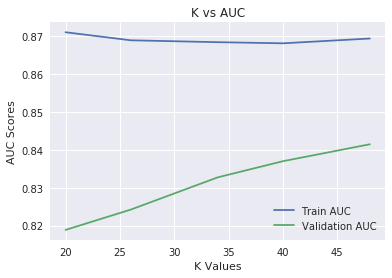



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


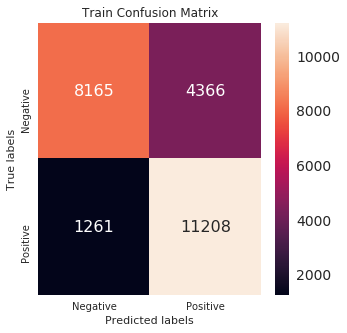

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.866221      0.719661
Recall         0.651584      0.898869
Fscore         0.743726      0.799344
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


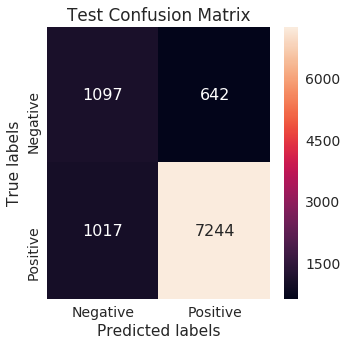

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.518921     0.918590
Recall        0.630822     0.876891
Fscore        0.569426     0.897256
Support    1739.000000  8261.000000


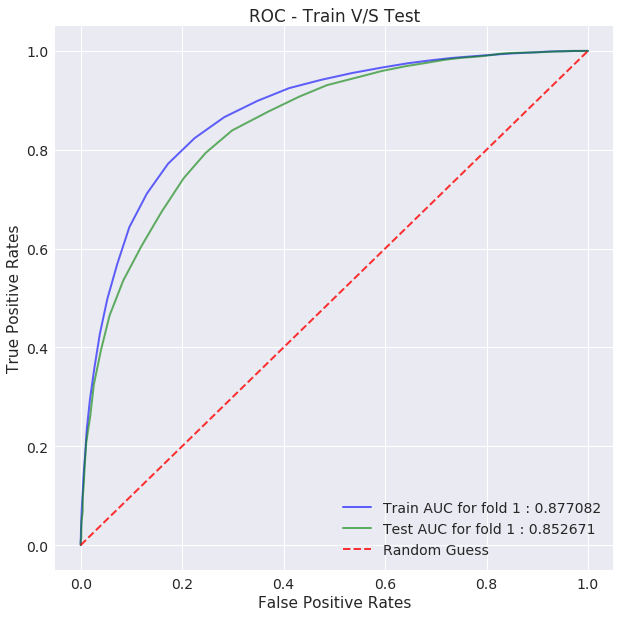

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8527'), ('f-score(-ve)', '56.9426'), ('f-score(+ve)', '89.7256')]


In [11]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)
# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_a1 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> As the value of K increases there is slight increase in test auc and slight decrease in train auc.
     The best K value selected is 48</li>
<li> Performance on +ve class is good(89% f-score) but negative class (56%) </li>
</ul>

### [A.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [12]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/train_bigram_tfidf.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/test_bigram_tfidf.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'brute', # 'brute', 'kd_tree',  
}

Train df shape (25000, 503)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 503)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,501, test features: 10000,501
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


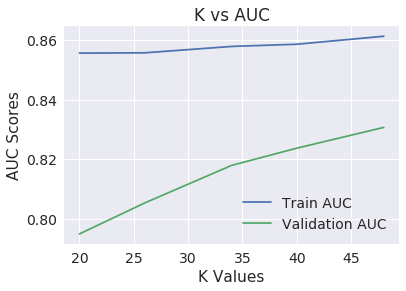



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


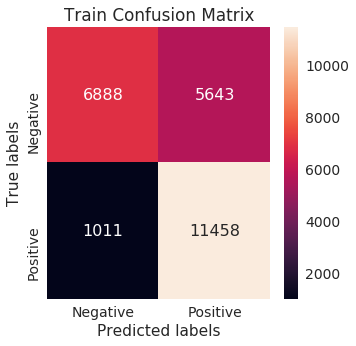

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.872009      0.670019
Recall         0.549677      0.918919
Fscore         0.674302      0.774975
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


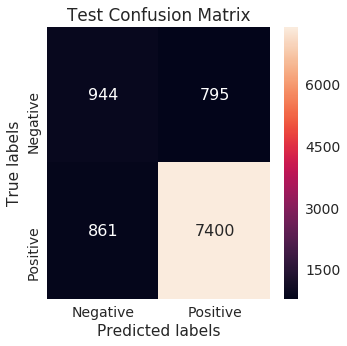

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.522992     0.902990
Recall        0.542841     0.895775
Fscore        0.532731     0.899368
Support    1739.000000  8261.000000


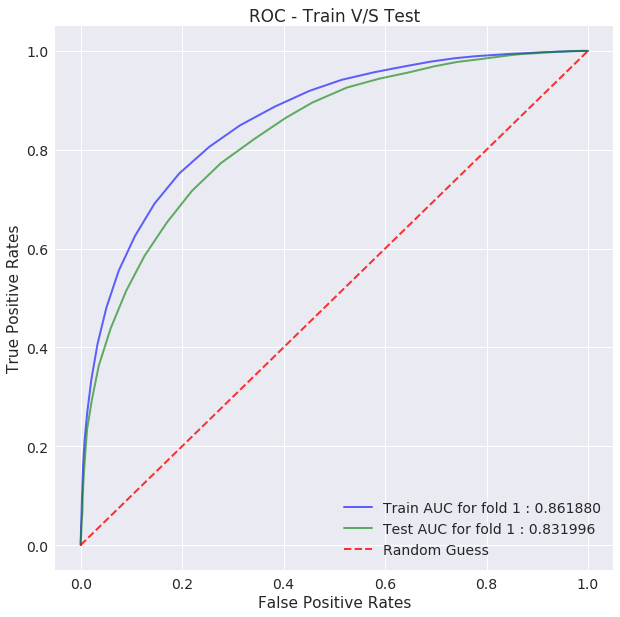

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8320'), ('f-score(-ve)', '53.2731'), ('f-score(+ve)', '89.9368')]


In [13]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_a2 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> As the value of K increases there is slight increase in test auc and train auc.
     The best K value selected is 48</li>
<li> Performance on +ve class is good(89% f-score) but negative class (53%) </li>
</ul>

### [A.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [14]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/train_avg_w2v.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/test_avg_w2v.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'brute', # 'brute', 'kd_tree',  
}

Train df shape (25000, 52)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 52)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,50, test features: 10000,50
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


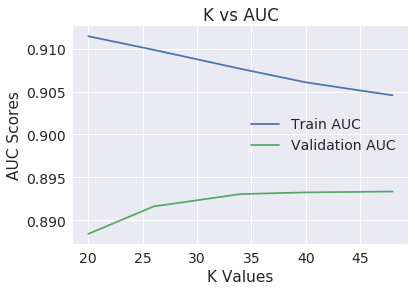



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


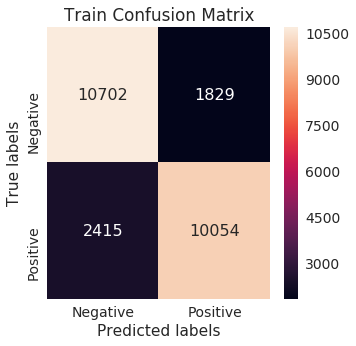

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.815888      0.846083
Recall         0.854042      0.806320
Fscore         0.834529      0.825723
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


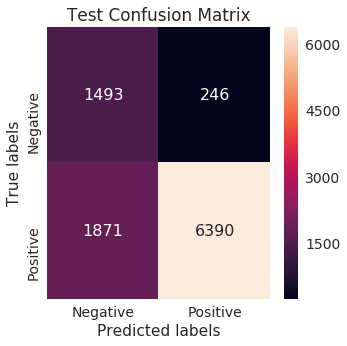

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.443817     0.962929
Recall        0.858539     0.773514
Fscore        0.585146     0.857891
Support    1739.000000  8261.000000


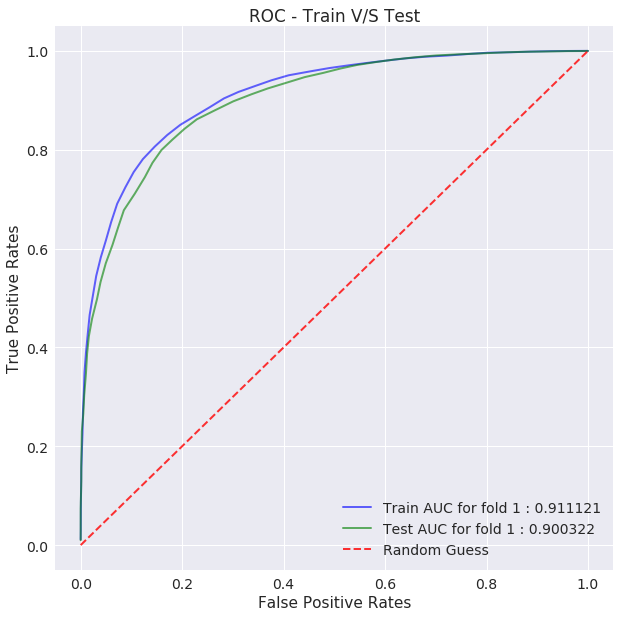

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.9003'), ('f-score(-ve)', '58.5146'), ('f-score(+ve)', '85.7891')]


In [15]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_a3 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> The hyper param K is selected in such a way that the deviation between train and validation
     curve is less and the validation AUC score is high </li>
<li> As the value of K increases there is slight increase in test auc and slight decrease in train auc.
     The best K value selected is 48 </li>
<li> F-score value for +ve is really good (85.78) but negative class (58.51)</li>
<li> ROC curves oerlap well and performance of model looks good</li>
</ul>

### [A.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [16]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/train_tf_w2v.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/test_tf_w2v.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'brute', # 'brute', 'kd_tree',  
}

Train df shape (25000, 52)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 52)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,50, test features: 10000,50
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


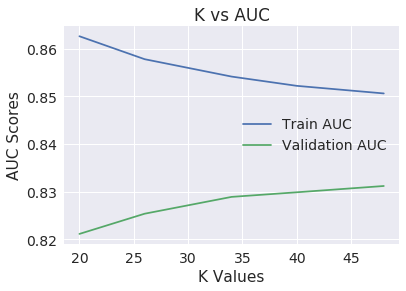



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


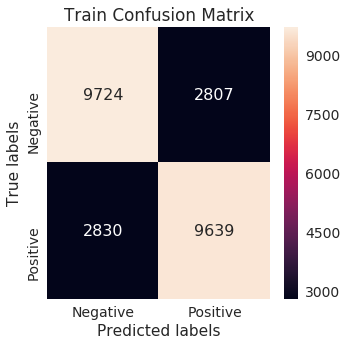

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.774574      0.774466
Recall         0.775996      0.773037
Fscore         0.775284      0.773751
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


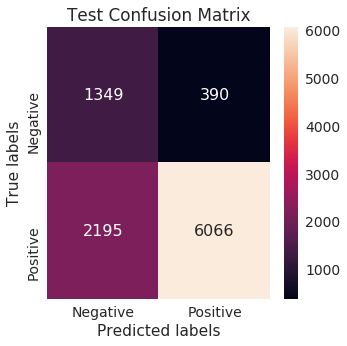

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.380643     0.939591
Recall        0.775733     0.734294
Fscore        0.510695     0.824353
Support    1739.000000  8261.000000


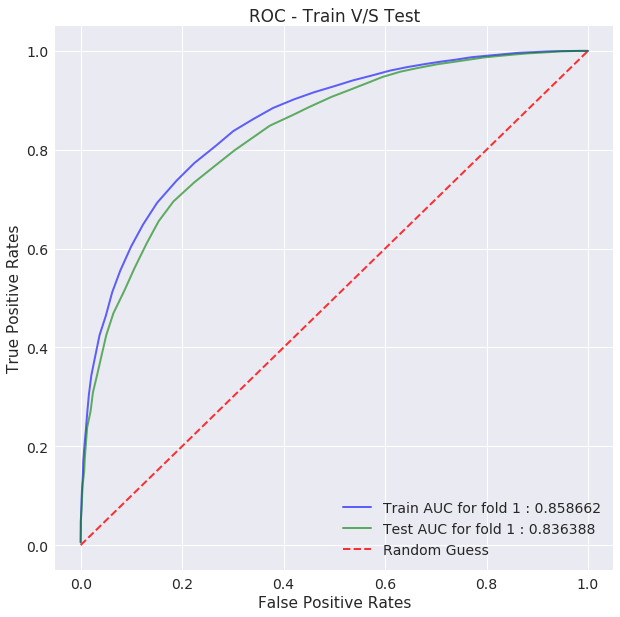

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8364'), ('f-score(-ve)', '51.0695'), ('f-score(+ve)', '82.4353')]


In [17]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_a4 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> Precision for -ve class is low (0.38) </li>
<li> There are many positive data points which are misscalssified (2195) </li>
</ul>

## [B] Applying KNN kd-tree

### [B.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [18]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/train_bow_bigram.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/BOW/test_bow_bigram.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'kd_tree', # 'brute', 'kd_tree',  
}

Train df shape (25000, 503)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 503)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,501, test features: 10000,501
Shape of -> train labels :25000, test labels: 10000


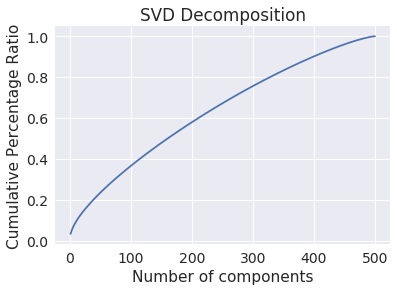

Num dimensions selected by SVD 456
Total variance captured:0.967530
Shape of train df:(25000,456), Test DF:(10000,456)


 The k vs AUC score plot


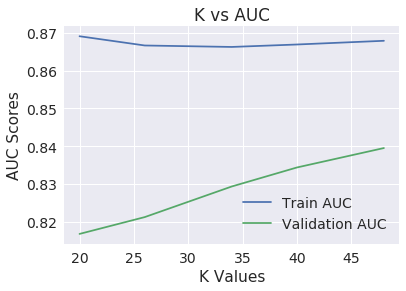



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


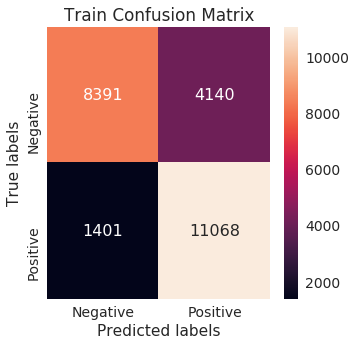

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.856924      0.727775
Recall         0.669619      0.887641
Fscore         0.751781      0.799798
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


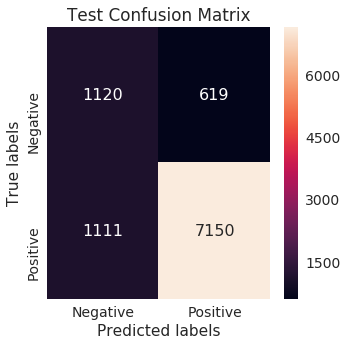

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.502017     0.920324
Recall        0.644048     0.865513
Fscore        0.564232     0.892077
Support    1739.000000  8261.000000


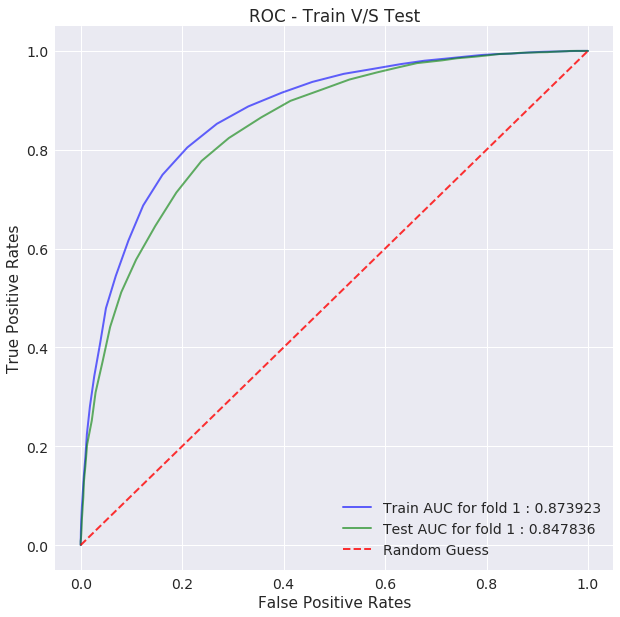

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8478'), ('f-score(-ve)', '56.4232'), ('f-score(+ve)', '89.2077')]


In [19]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=True)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_b1 = get_table_entry(model, auc_ts, ts_all_metrics_df)

## Observation

%%HTML
<ul>
<li> The number of components got reduced to 456 by SVD decomposition </li>
<li> The total variance captured is 96.75 %</li>
</ul>

### [B.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [20]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/train_bigram_tfidf.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF/test_bigram_tfidf.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'kd_tree', # 'brute', 'kd_tree',  
}

Train df shape (25000, 503)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 503)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,501, test features: 10000,501
Shape of -> train labels :25000, test labels: 10000


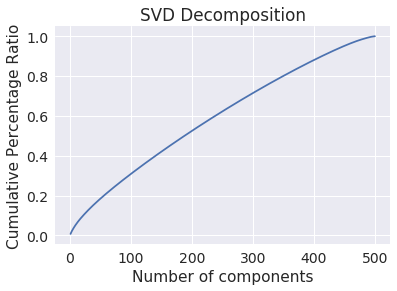

Num dimensions selected by SVD 474
Total variance captured:0.980770
Shape of train df:(25000,474), Test DF:(10000,474)


 The k vs AUC score plot


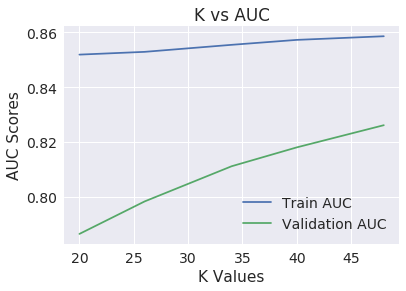



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


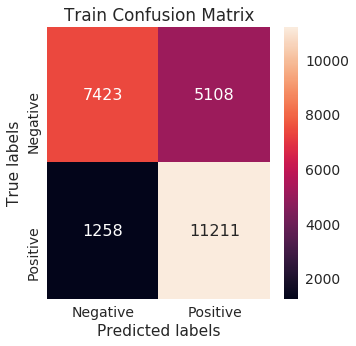

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.855086      0.686991
Recall         0.592371      0.899110
Fscore         0.699887      0.778866
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


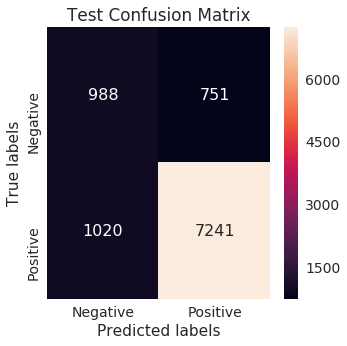

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.492032     0.906031
Recall        0.568143     0.876528
Fscore        0.527355     0.891036
Support    1739.000000  8261.000000


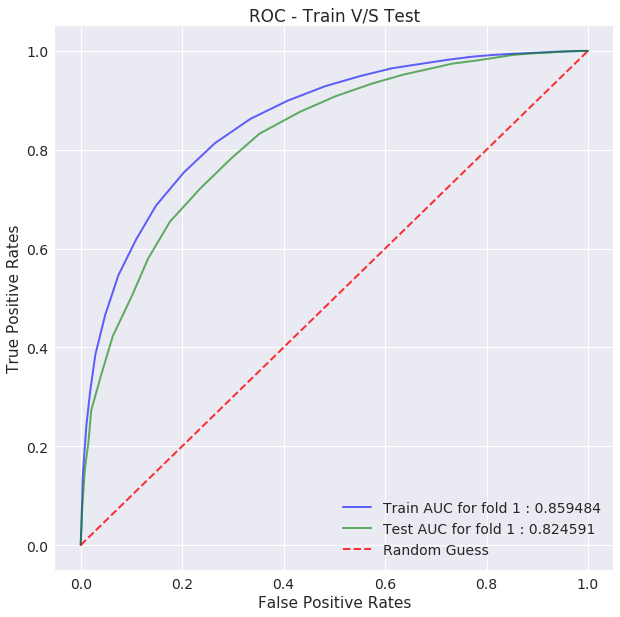

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8246'), ('f-score(-ve)', '52.7355'), ('f-score(+ve)', '89.1036')]


In [21]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=True)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_b2 = get_table_entry(model, auc_ts, ts_all_metrics_df)

## Observation

%%HTML
<ul>
<li> The SVD method reduced dimension of dataset to 471, covering 98% variances</li>
<li> k=48 is the best hyperparameter selected</li>
<li> Recall(0.56) and Precision (0.49) for -ve class is low </li>
</ul>

### [B.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [22]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/train_avg_w2v.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/AVG_W2V/test_avg_w2v.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'kd_tree', # 'brute', 'kd_tree',  
}

Train df shape (25000, 52)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 52)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,50, test features: 10000,50
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


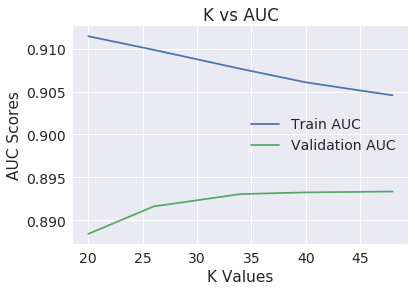



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


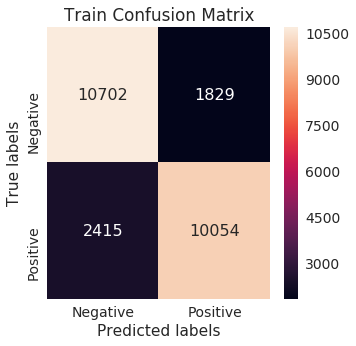

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.815888      0.846083
Recall         0.854042      0.806320
Fscore         0.834529      0.825723
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


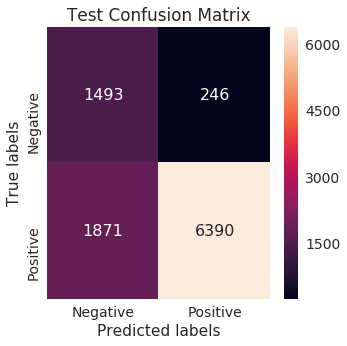

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.443817     0.962929
Recall        0.858539     0.773514
Fscore        0.585146     0.857891
Support    1739.000000  8261.000000


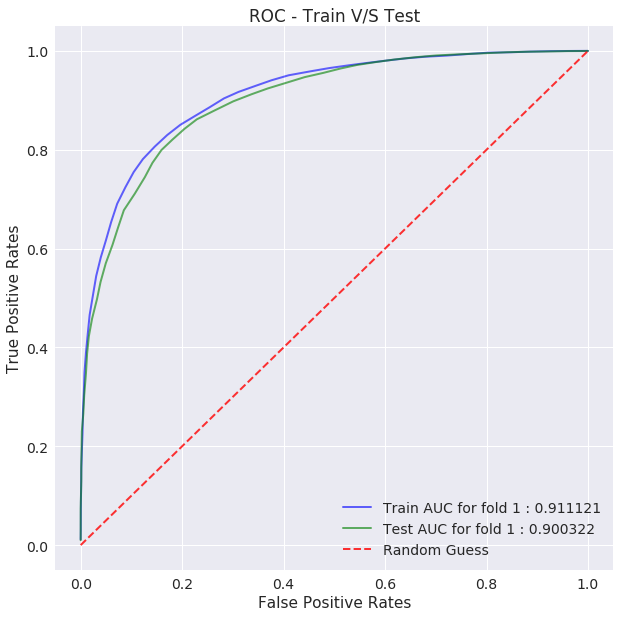

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.9003'), ('f-score(-ve)', '58.5146'), ('f-score(+ve)', '85.7891')]


In [23]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_b3 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> Precision for -ve class is low (0.43) </li>
<li> There are many positive data points which are misscalssified (1871) </li>
<li> As value of K increases test auc increases slightly and train auc decreases slightly</li>
</ul>

### [B.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [24]:
config_dict = {
    'train_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/train_tf_w2v.csv',
    'test_csv_path' : '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/TFIDF_W2V/test_tf_w2v.csv',
    'train_size' : 25000,
    'test_size' : 10000,
    'hyperparam_list' : [20, 26, 34, 40, 48],
    'algo_type' : 'kd_tree', # 'brute', 'kd_tree',  
}

Train df shape (25000, 52)
Class label distribution in train df:
 0    12531
1    12469
Name: Label, dtype: int64
Test df shape (10000, 52)
Class label distribution in test df:
 1    8261
0    1739
Name: Label, dtype: int64
Shape of ->  train features :25000,50, test features: 10000,50
Shape of -> train labels :25000, test labels: 10000


 The k vs AUC score plot


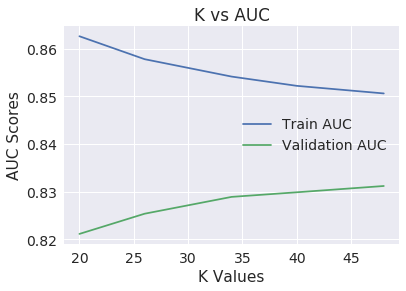



Best hyperparam value:  48


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


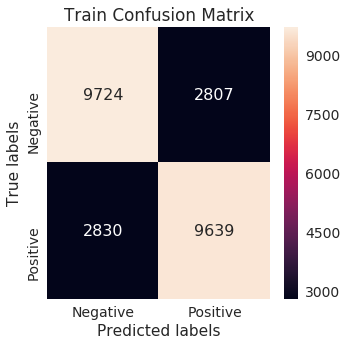

Train Evaluation Metrics : 
                Negative      Positive
Precision      0.774574      0.774466
Recall         0.775996      0.773037
Fscore         0.775284      0.773751
Support    12531.000000  12469.000000


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


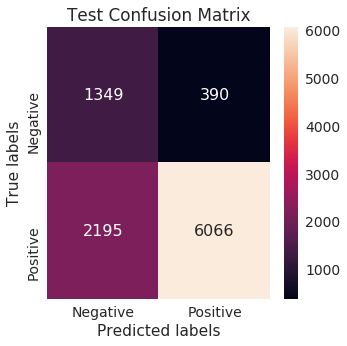

Test Evaluation Metrics : 
               Negative     Positive
Precision     0.380643     0.939591
Recall        0.775733     0.734294
Fscore        0.510695     0.824353
Support    1739.000000  8261.000000


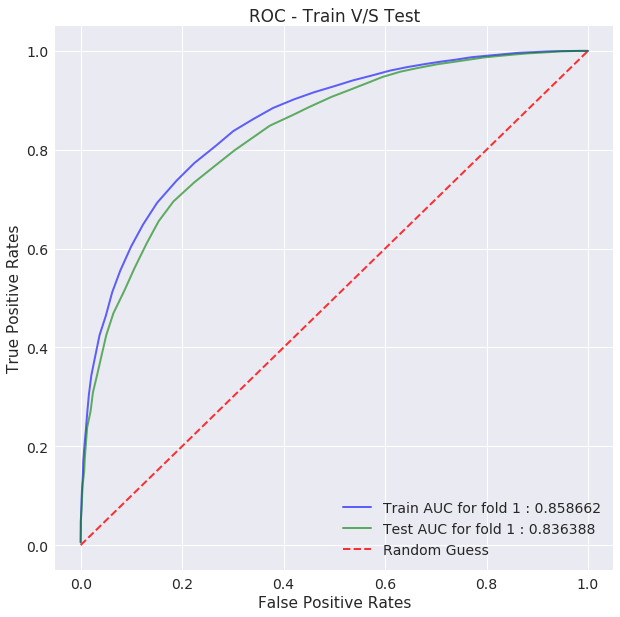

Results Summary: 
 [('Hyper Param', '48'), ('AUC', '0.8364'), ('f-score(-ve)', '51.0695'), ('f-score(+ve)', '82.4353')]


In [25]:
# read the train, test data and preprocess it
train_features, train_labels, test_features, test_labels = preprocess_data(config_dict,
                                                                            scaling=True,
                                                                            dim_reduction=False)

# train the model
model = train_model(config_dict, train_features, train_labels)

# evaluate trained model on train data
tr_eval_y_probs, tr_eval_y_value, tr_all_metrics_df = evaluate_model(model, train_features, train_labels, 'Train')

# evaluate trained model on test data
ts_eval_y_probs, ts_eval_y_value, ts_all_metrics_df = evaluate_model(model, test_features, test_labels, 'Test')

#  plotting performace of final model on train and test
tr_fold_prediction_list = list(zip([train_labels], [tr_eval_y_probs]))
ts_fold_prediction_list = list(zip([test_labels], [ts_eval_y_probs]))
auc_train, auc_ts = plot_roc_curves_pair(tr_fold_prediction_list, 
                                         ts_fold_prediction_list, 'Test',  
                                         plot=True)

# get entry for pretty table
ptabe_entry_b4 = get_table_entry(model, auc_ts, ts_all_metrics_df)

%%HTML
<ul>
<li> Precision for -ve class is low (0.38) </li>
<li> There are many positive data points which are misscalssified (2195) </li>
</ul>

# Procedure Summary

%%HTML
<ol>
<li> All data sets are preprocessed using standard scaler, for KD-Tree version the dimension is 
     reduced by applying TruncatedSVD algorithm </li>
<li> Two versio of KNN classifier is tried on all four datasets. Version 1: Brute force & Version 
     2: KD-Tree version </li>
<li> Trained all models usig all the four different data datasets with different hyper parameter (K) values.
<li> The best hyperparameter is selected using the cross validation method </li>
    
<li> The performance of each model is visualized by using ROC curve & confusion matrix heatmaps </li>
</ol>

# Results Summary

In [26]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Vectorizer', 'Method', 'Hyper-Param (K)', 'AUC', 'Fscore (-ve)', 'Fscore (+ve)']
Pret_table.title = 'KNN Results Summary'

In [27]:
# Brute Force
Pret_table.add_row(['BoW', 'Brute Force'] + ptabe_entry_a1)
Pret_table.add_row(['TF-IDF', 'Brute Force'] + ptabe_entry_a2)
Pret_table.add_row(['Avg W2V', 'Brute Force'] + ptabe_entry_a3)
Pret_table.add_row(['TF-IDF W2V', 'Brute Force'] + ptabe_entry_a4)
# KD Tree
Pret_table.add_row(['BoW Truncated SVD', 'KD-Tree'] + ptabe_entry_b1)
Pret_table.add_row(['TF-IDF Truncated SVD', 'KD-Tree'] + ptabe_entry_b2)
Pret_table.add_row(['Avg W2V', 'KD-Tree'] + ptabe_entry_b3)
Pret_table.add_row(['TF-IDF W2V', 'KD-Tree'] + ptabe_entry_b4)

In [28]:
print(Pret_table)

+---------------------------------------------------------------------------------------------+
|                                     KNN Results Summary                                     |
+----------------------+-------------+-----------------+--------+--------------+--------------+
|      Vectorizer      |    Method   | Hyper-Param (K) |  AUC   | Fscore (-ve) | Fscore (+ve) |
+----------------------+-------------+-----------------+--------+--------------+--------------+
|         BoW          | Brute Force |        48       | 0.8527 |   56.9426    |   89.7256    |
|        TF-IDF        | Brute Force |        48       | 0.8320 |   53.2731    |   89.9368    |
|       Avg W2V        | Brute Force |        48       | 0.9003 |   58.5146    |   85.7891    |
|      TF-IDF W2V      | Brute Force |        48       | 0.8364 |   51.0695    |   82.4353    |
|  BoW Truncated SVD   |   KD-Tree   |        48       | 0.8478 |   56.4232    |   89.2077    |
| TF-IDF Truncated SVD |   KD-Tree   |  

# Conclusions

%%HTML
<ul>
<li> The results otained are same for avg-w2v & tf-idf w2v vec models for both brute-force & KD-Tree version</li>
<li> The performance of the model on +ve class is really good (fscore for +ve is 82% above for any model) and 
     the performance on -ve class is not that good as the fscore for -ve class is below 59% for all model</li>
<li> Considering fscores of +ve & -ve class the best model is BoW  Brure Force </li>
<li> More complicated model can be tried to improve the performance </li>
</ul>